In [1]:
import torch

import numpy as np
import scipy.stats as st
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from Tools import NNE, EntropyKDE, KL, JSD
from Models import Generator

In [2]:
device='cpu'

In [3]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)

# Target density #

In [4]:
param_count=setup.param_count
logposterior=setup.logposterior



In [25]:
theta_mixed=torch.load('mlruns/1/eb8a9183fbab4df5b4487f91cfdf9de7/artifacts/theta.pt')[0:-1:4]
theta_sparse=torch.load('mlruns/1/6ad0cb2d83fd45e4bf0158423127e358/artifacts/theta.pt')[0:-1:1]
theta_ood3=torch.load('mlruns/1/5a0b4844d81c45bdad0d82651adafa25/artifacts/theta.pt')[0:-1:1]
theta_ood=torch.load('mlruns/1/80d92de68c0645d38650c6c56116c4a0/artifacts/theta.pt')[0:-1:1]
theta_ood4=torch.load('mlruns/1/b62011b2d434421cb64a2aa82ff74f3c/artifacts/theta.pt')[0:-1:1]
theta_ood2=torch.load('mlruns/1/f74e8ae0ff5c40729a93656e329e27dd/artifacts/theta.pt')

theta=[theta_sparse, theta_ood, theta_mixed]

GeNVI=Generator(5,param_count,device)
Model_dict=torch.load('results/f144be00f4c44877bd8104b576ff6b6f.pt', map_location=torch.device('cpu'))
#torch.load('results/897a12b6c98344edb6a0b9925e47c8cd.pt', map_location=torch.device('cpu'))
GeNVI.load_state_dict(Model_dict['state_dict'])

theta_ood4.shape
#Model_dict

torch.Size([1998, 151])

In [132]:
print(theta_ood2.mean())
print(theta_G.mean())


tensor(-0.0021)
tensor(-0.0504)


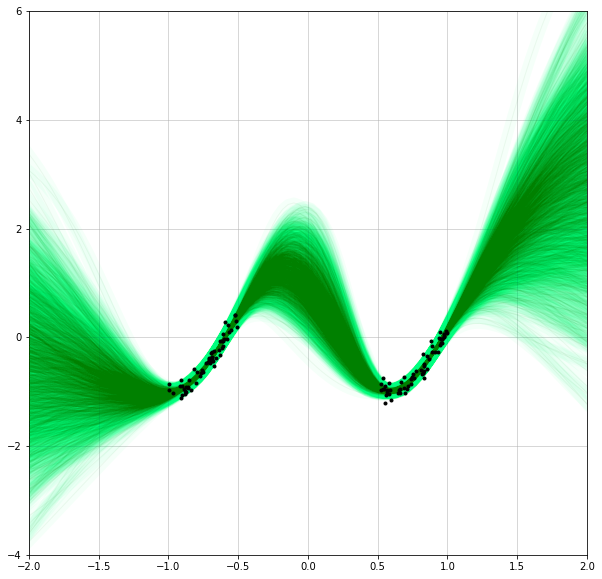

In [65]:
fig=setup.makePlot(theta_ood,device)

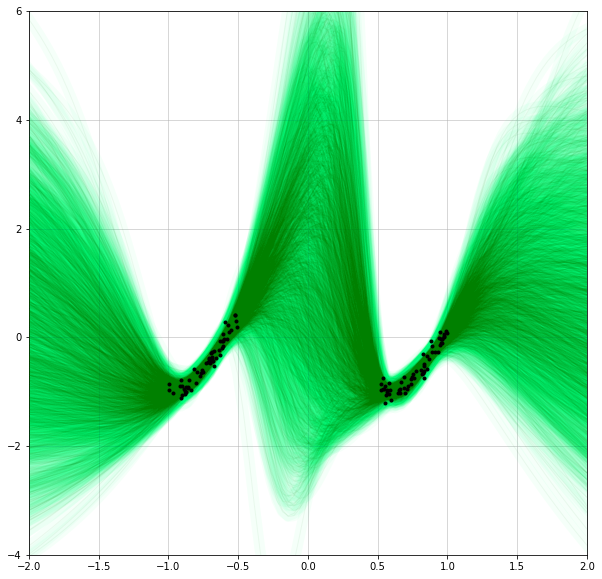

In [66]:
fig=setup.makePlot(theta_G,device)

In [26]:
ED = EntropyKDE(theta_ood[0:-1:2],device)
LP = logposterior(theta_ood[0:-1:2]).mean()
L = -ED - LP
print('ENTROPY(HMC):'+str(ED))
print('ELBO(HMC):'+str(L))

ENTROPY(HMC):tensor(146.0363)
ELBO(HMC):tensor(-20.9093)


In [27]:
ED = NNE(theta_ood[0:-1:2],1,1,device)
LP = logposterior(theta_ood[0:-1:2]).mean()
L = -ED - LP
print('ENTROPY(HMC):'+str(ED))
print('ELBO(HMC):'+str(L))

ENTROPY(HMC):tensor(137.1618)
ELBO(HMC):tensor(-12.0348)


In [94]:
print('KL(GeNVI,HMC)='+str(KL(theta_G,theta_ood)))
print('KL(HMC,GeNVI)='+str(KL(theta_ood,theta_G)))
print('JSD(HMC,GeNVI)='+str(.5*KL(theta_ood,theta_G)+.5*KL(theta_G,theta_ood)))


#d=(theta_ood.mean(dim=0)-theta_G.mean(dim=0)).norm()
#print(d)


KL(GeNVI,HMC)=tensor(481.7548)
KL(HMC,GeNVI)=tensor(169.0701)
JSD(HMC,GeNVI)=tensor(325.4124)


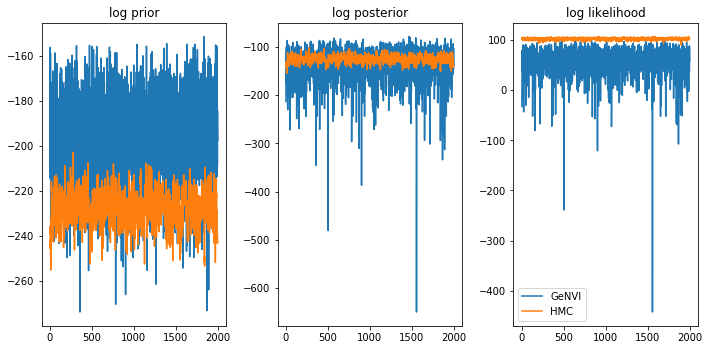

In [93]:
LL=setup.loglikelihood(theta_ood)
LP=setup.logposterior(theta_ood)
LPr=setup.logprior(theta_ood)

theta_G=GeNVI(2000).detach()
LL_G=setup.loglikelihood(theta_G)
LP_G=setup.logposterior(theta_G)
LPr_G=setup.logprior(theta_G)


fig, ax=plt.subplots(1,3, figsize=(10,5))

ax[0].plot(LPr_G, label='GeNVI')
ax[0].plot(LPr, label='HMC')
ax[0].set_title('log prior')
#plt.ylim(0,110)
#ax[0].set_legend()



ax[1].plot(LP_G, label='GeNVI')
ax[1].plot(LP, label='HMC')
ax[1].set_title('log posterior')
#plt.ylim(0,110)





ax[2].plot(LL_G, label='GeNVI')
ax[2].plot(LL, label='HMC')
ax[2].set_title('log likelihood')
#plt.ylim(0,110)
#ax[2].set_legend()

plt.legend()

plt.tight_layout(pad=1.2)



tensor(0.3139)


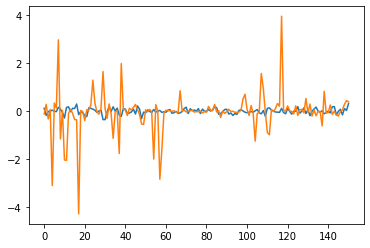

In [38]:
ZZ_G=theta_G.mean(dim=0)
ZZ=theta_ood.mean(dim=0)
plt.plot(ZZ)
plt.plot(ZZ_G)
print(ZZ[-1])

In [98]:
X=torch.arange(-2,2,0.027).to(device)
print('inputs X: '+str(X.shape[0])+' evenly spaced points in [-2,2]')
pred_G=setup.prediction(X,theta_G)
pred_HMC=setup.prediction(X,theta_ood)
print('KL(GeNVI_X,HMC_X)='+str(KL(pred_G,pred_HMC)))
print('KL(HMC_X,GeNVI_X)='+str(KL(pred_HMC,pred_G)))
print('JSD(HMC_X,GeNVI_X)='+str(.5*(KL(pred_HMC,pred_G)+KL(pred_G,pred_HMC))))

inputs X: 149 evenly spaced points in [-2,2]
KL(GeNVI_X,HMC_X)=tensor(146.5272)
KL(HMC_X,GeNVI_X)=tensor(137.4314)
JSD(HMC_X,GeNVI_X)=tensor(141.9793)


In [107]:
pred_G[:,0].unsqueeze(-1).shape

torch.Size([2000, 1])

In [127]:
J=torch.Tensor(X.shape[0])
K=torch.Tensor(X.shape[0])
K_=torch.Tensor(X.shape[0])




def JSD(X,Y):
    return 0.5*(KL(X,Y,k=20)+KL(Y,X,k=20))
for x in range(X.shape[0]):
    K[x]=KL(pred_HMC[:,x].unsqueeze(-1),pred_G[:,x].unsqueeze(-1),k=30)
    K_[x]=KL(pred_G[:,x].unsqueeze(-1),pred_HMC[:,x].unsqueeze(-1),k=30)

J=0.5*(K+K_)

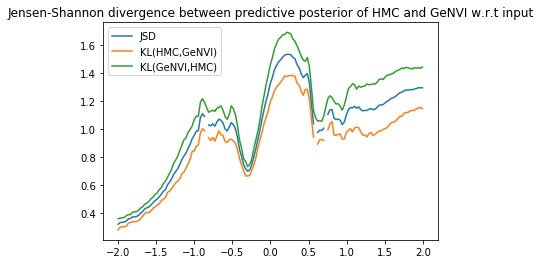

In [128]:
plt.plot(X,J, label='JSD')
plt.plot(X,K,  label='KL(HMC,GeNVI)')
plt.plot(X,K_,  label='KL(GeNVI,HMC)')
plt.title('Jensen-Shannon divergence between predictive posterior of HMC and GeNVI w.r.t input')
plt.legend()

In [46]:
theta_G.mean(dim=0).norm()

tensor(10.1574)

tensor(0.1561)


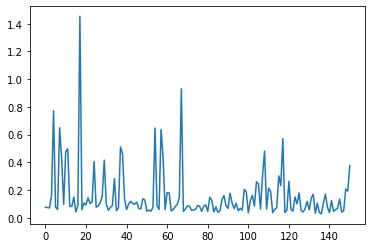

In [33]:
std=theta_G.std(dim=0)
plt.plot(std)
print(std.mean())

tensor([ 0.0492, -0.1771, -0.0306, -0.0336,  0.0400, -0.0619,  0.0214,  0.1711,
         0.1337, -0.0667, -0.2198,  0.1958,  0.2140, -0.0415,  0.0700,  0.1332,
         0.3533, -0.1969,  0.0164,  0.0413, -0.0997, -0.3078,  0.0922,  0.0078,
         0.1074,  0.0043, -0.0608, -0.0243,  0.1484, -0.2894, -0.3473,  0.0486,
         0.1639, -0.0314,  0.2419, -0.0282,  0.1268, -0.1434, -0.3506,  0.1060,
        -0.0053, -0.0549, -0.1651, -0.1041,  0.2002, -0.0726,  0.2040,  0.1049,
        -0.3742,  0.0154, -0.0511,  0.0281, -0.0141, -0.0526,  0.1193,  0.0027,
         0.0169,  0.0479, -0.0621, -0.0668, -0.1024,  0.0091,  0.1103, -0.1680,
        -0.1387, -0.0039, -0.0806,  0.0049, -0.0154,  0.0616,  0.1153, -0.0827,
         0.1556,  0.0581, -0.0039, -0.0535,  0.1613, -0.0947,  0.1237, -0.0428,
        -0.0406,  0.0917,  0.0449,  0.1223,  0.2289,  0.1698, -0.1151,  0.0232,
        -0.0253,  0.0166, -0.0572, -0.0922, -0.0307, -0.1942, -0.0862, -0.1858,
         0.0116,  0.0559,  0.0310, -0.09

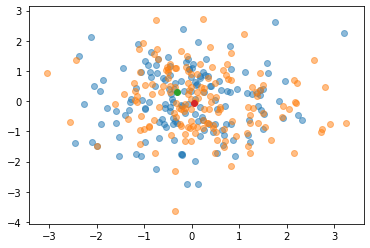

In [11]:
diff=theta_ood.mean(dim=0)-theta_ood2.mean(dim=0)
_,index =diff.abs().sort()
print(diff)
print(index)

plt.scatter(theta_ood[index[-1]],theta_ood[index[-2]],alpha=0.5)
plt.scatter(theta_ood2[index[-1]],theta_ood2[index[-2]],alpha=0.5)
plt.scatter(theta_ood.mean(dim=0)[index[-1]],theta_ood.mean(dim=0)[index[-2]])
plt.scatter(theta_ood2.mean(dim=0)[index[-1]],theta_ood2.mean(dim=0)[index[-2]])

In [18]:
from sklearn.manifold import TSNE
theta1=theta_ood
theta2=theta_ood2
theta_all=torch.cat([theta1, theta2])
theta_c=torch.cat([0.1*torch.ones(theta1.shape[0]),0.5*torch.ones(theta2.shape[0])])
myTSNE=TSNE(n_components=2,init='pca',perplexity=100)
X_embedded_ =myTSNE.fit_transform(theta_all.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.8333433866500854


(3998, 2)

In [19]:
X_embedded_[:,0].shape

(3998,)

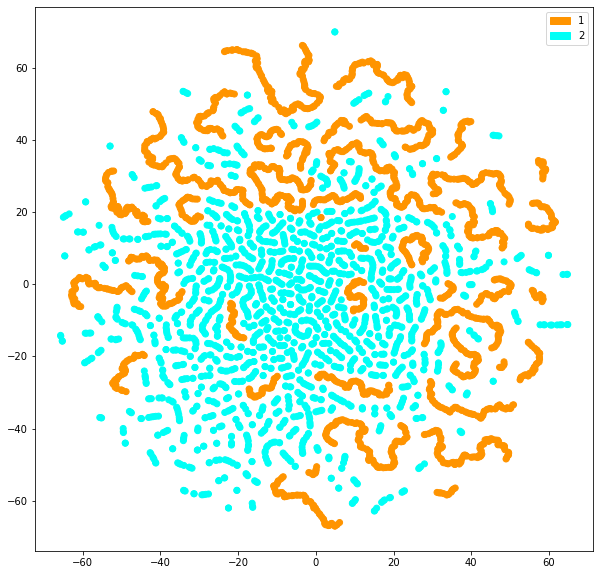

In [20]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig, ax = plt.subplots(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(.1), label='1')
G2_patch = mpatches.Patch(color=cmap(.5), label='2')
#G3_patch = mpatches.Patch(color=cmap(.2), label='G3')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_[:,0],X_embedded_[:,1],
           #X_embedded_[:,2],
           color=cmap(theta_c), 
           #linewidth=0.2,
           cmap=cmap)


#ax.view_init(elev=20., azim=170)

plt.legend(handles=[G1_patch,G2_patch])
#plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.savefig('tSNE.pdf')
plt.show()

In [82]:


X=torch.arange(-2,2,0.02).to(device)

pred=[setup.prediction(X,theta[i]) for i in range(len(theta))]
pred[0].shape

torch.Size([1998, 200])

In [67]:
pred_=pred[0][0:-1:2]
ED=[]
ED_=[]
for i in range(len(theta)):
    pred_=pred[i]
    K=torch.Tensor(X.shape[0])
    KK=torch.Tensor(X.shape[0])
    for x in range(X.shape[0]):
        K[x]=NNE(pred_[:,x].unsqueeze(-1),10,device)#
        KK[x]=EntropyKDE(pred_[:,x].unsqueeze(-1),device)
    ED.append(K)
    ED_.append(KK)
    
    

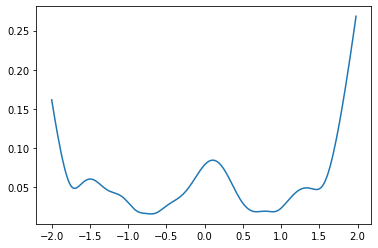

In [91]:
plt.plot(X,pred[2].std(dim=0))
    
    

In [22]:
for i in range(len(theta)):
    print(emcee.autocorr.integrated_time(theta[i], c=5, tol=50, quiet=False))

[6.30528152]
[18.79204281]
[31.99413624]


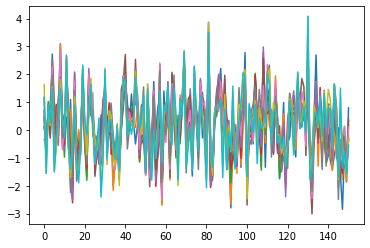

In [94]:
%matplotlib inline
for i in range(10):#theta.shape[1]):
    plt.plot(theta[i])

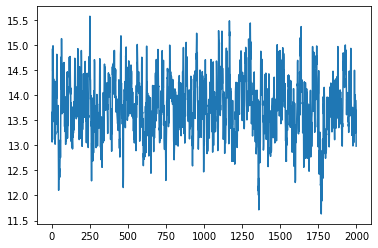

In [95]:
plt.plot(torch.as_tensor(theta).norm(dim=1))

In [96]:
theta=torch.as_tensor(theta)
theta_n=theta-theta.mean()
corr = np.correlate(theta_n,theta_n,mode='full')/theta_n.shape[0]
corr = corr[corr.size//2:]



ValueError: object too deep for desired array

In [23]:
def ESS(x):
    """ Compute the effective sample size of estimand of interest. PyMC's implementation. """
    m_chains, n_iters = x.shape

    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t])**2 for i in range(t, n_iters)) for j in
                               range(m_chains)) / (m_chains * (n_iters - t)))

    post_var = gelman_rubin(x)

    t = 1
    rho = np.ones(n_iters)
    negative_autocorr = False

    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n_iters):
        rho[t] = 1 - variogram(t) / (2 * post_var)

        if not t % 2:
            negative_autocorr = sum(rho[t-1:t+1]) < 0

        t += 1

    return int(m_chains * n_iters / (1 + 2*rho[1:t].sum()))

def gelman_rubin(x):
    """ Estimate the marginal posterior variance. PyMC's implementation. """
    m_chains, n = x.shape

    # Calculate between-chain variance
    B_over_n = ((np.mean(x, axis=1) - np.mean(x))**2).sum() / (m_chains - 1)

    # Calculate within-chain variances
    W = np.sum([(x[i] - xbar) ** 2 for i, xbar in enumerate(np.mean(x, 1))]) / (m_chains * (n - 1))

    # (over) estimate of variance
    s2 = W * (n - 1) / n + B_over_n

    return s2

In [98]:

ESS(theta_n.numpy())

311696

In [101]:
theta_n.shape[0]*theta_n.shape[1]

301849

In [104]:

samples.shape, theta.shape

(torch.Size([6000, 151]), torch.Size([1999, 151]))

tensor(-2.5333)


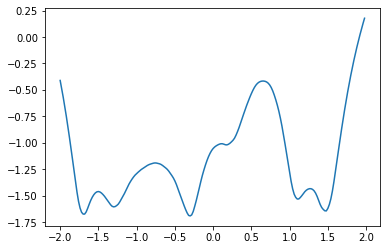

In [40]:
import seaborn as sns

#sns.distplot(pred_[:,100])
plt.plot(X,K)
print(NNE(pred_[:,100].unsqueeze(-1),1,device))

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

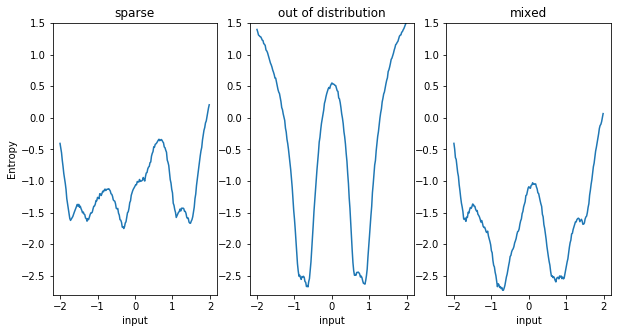

In [68]:
title=['sparse','out of distribution', 'mixed']
fig, ax= plt.subplots(1,3, figsize=(10,5))
for i in range(len(theta)):
    ax[i].plot(X,ED[i])
    ax[i].set_ylim(-2.8,1.5)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('input')
ax[0].set_ylabel('Entropy')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

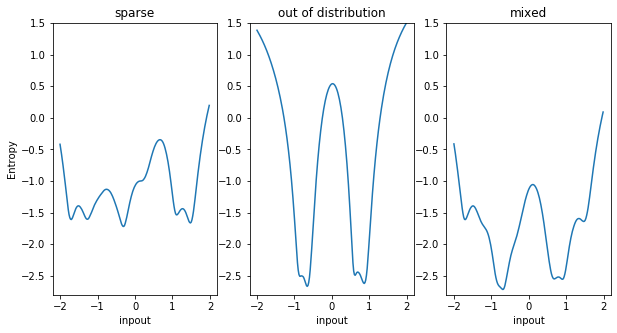

In [58]:
title=['sparse','out of distribution', 'mixed']
fig, ax= plt.subplots(1,3, figsize=(10,5))
for i in range(len(theta)):
    ax[i].plot(X,ED_[i])
    ax[i].set_ylim(-2.8,1.5)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('input')
ax[0].set_ylabel('Entropy')
plt.tight_layout

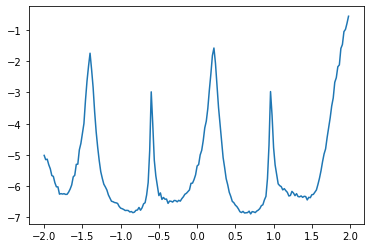

In [13]:
plt.plot(X,K)

In [74]:
NNE(theta_ood,k=1,device=device)

tensor(187.5856)

In [20]:
import emcee
emcee.autocorr.integrated_time(samples, c=5, tol=50, quiet=False)

NameError: name 'samples' is not defined

In [22]:
for i in range(len(theta)):
    print(emcee.autocorr.integrated_time(theta[i], c=5, tol=50, quiet=False))

[6.30528152]
[18.79204281]
[31.99413624]


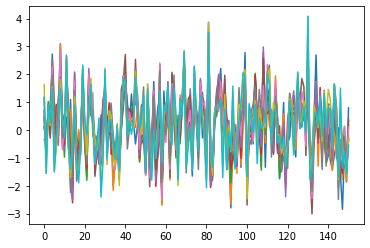

In [94]:
%matplotlib inline
for i in range(10):#theta.shape[1]):
    plt.plot(theta[i])

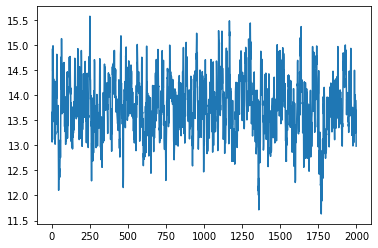

In [95]:
plt.plot(torch.as_tensor(theta).norm(dim=1))

In [96]:
theta=torch.as_tensor(theta)
theta_n=theta-theta.mean()
corr = np.correlate(theta_n,theta_n,mode='full')/theta_n.shape[0]
corr = corr[corr.size//2:]



ValueError: object too deep for desired array

In [23]:
def ESS(x):
    """ Compute the effective sample size of estimand of interest. PyMC's implementation. """
    m_chains, n_iters = x.shape

    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t])**2 for i in range(t, n_iters)) for j in
                               range(m_chains)) / (m_chains * (n_iters - t)))

    post_var = gelman_rubin(x)

    t = 1
    rho = np.ones(n_iters)
    negative_autocorr = False

    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n_iters):
        rho[t] = 1 - variogram(t) / (2 * post_var)

        if not t % 2:
            negative_autocorr = sum(rho[t-1:t+1]) < 0

        t += 1

    return int(m_chains * n_iters / (1 + 2*rho[1:t].sum()))

def gelman_rubin(x):
    """ Estimate the marginal posterior variance. PyMC's implementation. """
    m_chains, n = x.shape

    # Calculate between-chain variance
    B_over_n = ((np.mean(x, axis=1) - np.mean(x))**2).sum() / (m_chains - 1)

    # Calculate within-chain variances
    W = np.sum([(x[i] - xbar) ** 2 for i, xbar in enumerate(np.mean(x, 1))]) / (m_chains * (n - 1))

    # (over) estimate of variance
    s2 = W * (n - 1) / n + B_over_n

    return s2

In [98]:

ESS(theta_n.numpy())

311696

In [101]:
theta_n.shape[0]*theta_n.shape[1]

301849

In [104]:

samples.shape, theta.shape

(torch.Size([6000, 151]), torch.Size([1999, 151]))

In [55]:
dim=3
G=torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(dim), 1.*torch.eye(dim))
G01=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

In [56]:
G.entropy()


tensor(4.2568)

In [57]:
test_sample=G.sample((1000,))
prior_sample=G01.sample((1000,))

In [58]:
NNE(test_sample,k=1,device=device)

tensor(4.2536)

In [59]:
EntropyKDE(test_sample,device)

tensor(4.1375)

In [60]:
KL(test_sample,prior_sample,k=3)

tensor(1.1832)

In [6]:
K=torch.Tensor(151)
K_=torch.Tensor(151)
K_t=torch.Tensor(151)
for dim in range(1,151):

    mu=1.*torch.ones(dim)
    
    G=torch.distributions.multivariate_normal.MultivariateNormal(mu, 1.*torch.eye(dim))
    G01=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    test_sample=G.sample((1000,))
    prior_sample=G01.sample((1000,))
    
    K_[dim]=KL(prior_sample,test_sample,k=2,p=2)
    K_t[dim]=KL(prior_sample,test_sample,k=2,p=1)
    
    sigma=1.*torch.ones(dim)
    K[dim]=0.5*(mu**2+sigma**2-(sigma**2).log()-1).sum()

Text(0.5, 0, 'dimension')

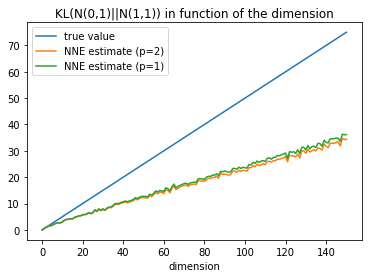

In [7]:
plt.plot(K, label='true value')
plt.plot(K_, label='NNE estimate (p=2)')
plt.plot(K_t, label='NNE estimate (p=1)')
plt.title('KL(N(0,1)||N(1,1)) in function of the dimension')
plt.legend()
plt.xlabel('dimension')

In [23]:
5**5

3125

In [ ]:
K_=torch.Tensor(4)
    
dim=20

G=torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(dim), 1.*torch.eye(dim))

G01=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

for N in range(1,6):


    test_sample=G.sample((10**N,))
    prior_sample=G01.sample((10**N,))
    
    K_[N-1]=KL(prior_sample,test_sample,k=1)
    


In [51]:
mu=torch.ones(dim)
sigma=1.*torch.ones(dim)
K=0.5*(mu**2+sigma**2-(sigma**2).log()-1).sum()*torch.ones(4)

Text(0.5, 0, 'log base 10 sample size')

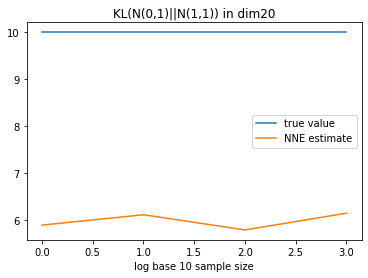

In [52]:
plt.plot(K, label='true value')
plt.plot(K_, label='NNE estimate')
plt.title('KL(N(0,1)||N(1,1)) in dim'+str(dim))
plt.legend()
plt.xlabel('log base 10 sample size')

In [84]:
K=torch.Tensor(151)
K_=torch.Tensor(151)
for dim in range(1,151):

    G01=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    test_sample=G.sample((1000,))
    prior_sample=G.sample((1000,))
    
    K_[dim]=KL(prior_sample,test_sample,k=1)
    
    mu=torch.ones(dim)
    sigma=1.*torch.ones(dim)
    K[dim]=0.5*(mu**2+sigma**2-(sigma**2).log()-1).sum()

Text(0.5, 0, 'dimension')

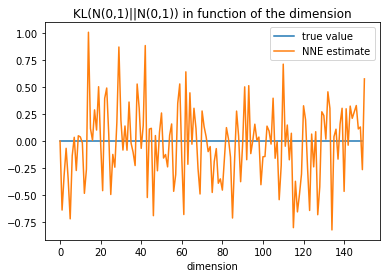

In [83]:
plt.plot(torch.zeros(150), label='true value')
plt.plot(K_, label='NNE estimate')
plt.title('KL(N(0,1)||N(0,1)) in function of the dimension')
plt.legend()
plt.xlabel('dimension')

In [70]:
E=torch.Tensor(151)
E_=torch.Tensor(151)
E_KDE=torch.Tensor(151)
for dim in range(1,151):

    G01=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    prior_sample=G01.sample((1000,))
    
    E_[dim]=NNE(prior_sample,k=1,device=device)
    E_KDE[dim]=EntropyKDE(prior_sample,device)
    
    E[dim]=G01.entropy()

Text(0.5, 0, 'dimension')

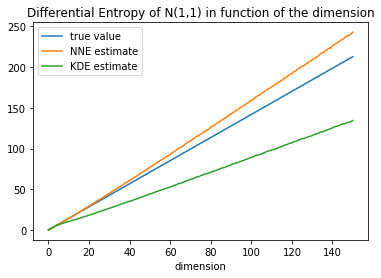

In [79]:
plt.plot(E, label='true value')
plt.plot(E_, label='NNE estimate')
plt.plot(E_KDE, label='KDE estimate')
plt.title('Differential Entropy of N(1,1) in function of the dimension')
plt.legend()
plt.xlabel('dimension')